In [1]:
%matplotlib inline
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from preprocessing import *
import cv2


from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Lambda
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

import time


# to autoreload modules on code change
%load_ext autoreload
%autoreload 2


/home/u8710/.conda/envs/my_root/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = get_emotion_data(scale=False)

In [3]:
def convert_shape(dfs): # convert images into 4d from 2d and viceversa
    ret_dfs = [0]*len(dfs)
    for i,df in enumerate(dfs):
        df2 = np.zeros((df.shape[0],200,200))
        temp = np.zeros((df.shape[0],200,200,3))
        df = df.reshape(-1,48,48)
        for j in range(df.shape[0]):
            df2[j] = cv2.resize(df[j],(200,200))
        temp[:,:,:,0] = df2
        temp[:,:,:,1] = df2
        temp[:,:,:,2] = df2
        print(temp.shape)
        ret_dfs[i] = temp
    return ret_dfs

In [8]:
for j,i in enumerate([X_train, y_train, X_val, y_val, X_test, y_test]):
    print(i.shape)
    if j%2 != 0:
        print('----------------------------------------')
        bc = np.bincount(i.astype(int).reshape(-1))
        sm = bc.sum()
        print(bc/sm) # to check if sampling is stratified
        print()

(28709, 2304)
(28709, 1)
----------------------------------------
[0.13915497 0.01518688 0.14270786 0.25131492 0.16823992 0.11045317
 0.17294228]

(3589, 2304)
(3589, 1)
----------------------------------------
[0.13011981 0.01560323 0.13820006 0.24937308 0.18194483 0.1156311
 0.16912789]

(3589, 2304)
(3589, 1)
----------------------------------------
[0.13680691 0.0153246  0.14711619 0.24491502 0.16550571 0.11590972
 0.17442184]



In [11]:
datagen = ImageDataGenerator(
#         featurewise_center=True,
#         featurewise_std_normalization=True,
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
        rescale=1./255,
#         shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
#         preprocessing_function= lambda x: cv2.resize(x,(150,150))
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
#         preprocessing_function= lambda x: cv2.resize(x,(150,150))
)

# datagen.fit(X_train.reshape(-1,48,48,1))

In [4]:
# since = time.time()
X_train,X_val,X_test = convert_shape([X_train,X_val,X_test])
# elapsed = time.time() - since

(28709, 200, 200, 3)
(3589, 200, 200, 3)
(3589, 200, 200, 3)


In [ ]:
resized_data = {'train':(X_train,y_train),
                'val':(X_val,y_val),
                'test':(X_test,y_test)
               }

In [6]:
print('elapsed tim in resizing in {:.0f}m {:.0f}s'.format(elapsed // 60, elapsed % 60))

elapsed tim in resizing in 0m 20s


In [5]:
import klepto
d = klepto.archives.dir_archive('stuff', cached=True, serialized=True)

In [8]:
d['train'] = {'a':X_train[:5000]}

In [9]:
d.dump()

error: 'I' format requires 0 <= number <= 4294967295

In [12]:
bs = 32
dl = datagen.flow(X_train, y_train, batch_size=32,shuffle=True,seed=1)
test_dl = datagen.flow(X_val, y_val, batch_size=32,shuffle=True,seed=1)

MemoryError: 

28709
(1, 48, 48, 3) (1, 1)


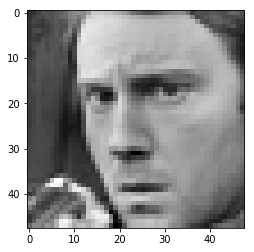

In [8]:
print(len(iter(dl)))
a = iter(dl)[0]
print(a[0].shape,a[1].shape)
plt.imshow(a[0][0,:,:,2],cmap='gray')

In [9]:
(a[0][0,:,:,0]  != a[0][0,:,:,1]).any()

False

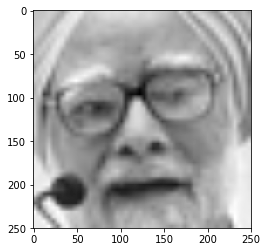

In [12]:
img = X_train[1].reshape(48,48,3)
img = cv2.resize(img,(250,250))
plt.imshow(img[:,:,1],cmap='gray')


In [63]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=shp)

In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 100, 100, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [50]:
for layer in model.layers:
    layer.trainable = False

In [65]:
temp = model.layers[0]

In [68]:
model.layers[0] = Sequential()
model.layers[0].add(Lambda(lambda image: k.tf.image.resize_images(image, (200, 200)),batch_input_shape=(bs,48,48,3)))
model.layers[0].add(temp)

In [69]:
model.layers[0]

In [70]:
model.layers[0].build((bs,200,48,3))

In [71]:
model.layers[1].input

<tf.Tensor 'input_4:0' shape=(?, 200, 200, 3) dtype=float32>

In [72]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequential_10 (Sequential)      (32, 200, 200, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 100, 100, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [75]:
model.layer[1].build()

AttributeError: 'Model' object has no attribute 'layer'

In [73]:
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

In [74]:
model2 = Model(inputs = model.input, outputs = predictions)

/home/u8710/.conda/envs/my_root/lib/python3.6/site-packages/keras/engine/topology.py:1590: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "model_2" was not an Input tensor, it was generated by layer input_4.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: input_4:0
  str(x.name))


AttributeError: Layer input_4 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

In [57]:
model2.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [58]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [59]:
model2.fit_generator(dl,
samples_per_epoch = X_train.shape[0],
epochs = 1,
validation_data = test_dl,
nb_val_samples = X_val.shape[0],
callbacks = [checkpoint, early])

/home/u8710/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/u8710/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=1, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=897, validation_steps=3589)`


Epoch 1/1


ValueError: Error when checking input: expected input_3 to have shape (200, 200, 3) but got array with shape (48, 48, 3)

In [ ]:
# model_final.fit_generator(train_generator,
# samples_per_epoch = nb_train_samples,
# epochs = epochs,
# validation_data = validation_generator,
# nb_val_samples = nb_validation_samples,
# callbacks = [checkpoint, early])